In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import poisson
from scipy.special import gammaln
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm, binom
import scipy.stats as st
from sklearn.linear_model import PoissonRegressor
import pyreadr
np.random.seed(42)
# matplotlibで日本語を使えるように
plt.rcParams["font.family"] = "IPAGothic"

In [2]:
data4a = pd.read_csv("./binomial/data4a.csv")

<h1>6 一般化線形モデルの応用範囲をひろげる</h1>

この章ではさまざまな一般化線形モデルについて扱います。  
「ある出来事が発生する確率」の統計モデルであるロジスティック回帰、人口密度などの割算地を扱うポアソン回帰のオフセット頂、  
正規分布やガンマ分布を使う一般化線形モデルについて学んでいきます。

<h1>6.1 様々な種類のデータで応用できる一般化線形モデル</h1>

一般化線形モデルの特徴は確率分布・リンク関数・線形予測子の組み合わせを指定することによってさまざまなタイプのデータを表現できることです。  
下の表には「この確率分布ならこのリンク関数を使う」といった一覧です。  
|    |確率分布|目的変数|statsmodelsのfamily指定|よく使うリンク関数|乱数生成|
|----|----|----|----|----|----|
|離散|二項分布|有限な整数|sm.families.Binomial()|logit|np.random.binomial()|
|離散|ポアソン分布|非負整数(平均=分散)|sm.families.Poisson()|log|np.random.poisson()|  
|離散|負の二項分布|非負整数(平均<分散)|sm.families.NegativeBinomial()|log|scipy.stats.nbinom.rvs()|
|連続|ガンマ分布|正の実数値|sm.families.Gamma()|inverse(逆数)|np.random.gamma()|
|連続|正規分布|全ての実数値|sm.families.Gaussian()|identity(恒等関数)|np.random.normal()|  
    
応答変数を線形変換して直線回帰をすることと、一般化線形モデルでリンク関数を指定することは全く別のものです。  


<h1>6.2 例題:上限のあるカウントデータ</h1>

まず、二項分布を使った一般化線形モデルについて扱います。ポアソン分布は上限のないカウントデータを表現するのに使いましたが、  
二項分布は上限のあるカウントデータ{$0,1,2,….N$}といった範囲をとる現象のばらつきを表現するために使います。  
例えば、「N個体の実験対象に同じ処理をしたら、&y&個体で反応が陽性、$N-y$個体では陰性だった」という構造のデータは二項分布を使って説明できるかもしれません。  
  
この章の例題では応答変数$y_i$の上限が$N$である架空植物のデータを使います。  
ある架空植物の個体$i$それぞれにおいて「$N_i$個の観測種子のうち生きていて発芽能力があるものは$y_i$個、死んだ種子は$N_i-y_i$個」といった観測データが得られたとします。個体ごとに異なる体サイズ$x_i$や生育環境$f_i$に左右されて、種子の生き残る確率が上下すると考えられます。このようなデータが全部で100個体分あるとします。  
ここでは観測種子数$N_i$がどの個体でも$8$個とします。応答変数$y_i$のとりうる値は{$0,1,2,…,N$}であり、全部生存していた場合$y_i=8$、全種子が死亡していたら$y_i=0$です。  
また、ある個体$i$から得られた1個の種子が生きている確率を生存確率といい、$q_i$であらわすこととします。
説明変数については、個体の大きさをあらわす体サイズ$x_i$があり、この$x_i$によって生存確率$q_i$が上下するものとします。  
また全100個体のうち50個体は特に何もしていない(無処理$f_i=C$)、残り50個体には肥料を与えたとします(施肥処理$f_i=T$)  
この例題で調べたいのはある個体の生存確率$q_i$が体サイズ$x_i$や施肥処理$f_i$といった説明変数によって、どう変化するのかという点であり、これを統計モデルのパラメータ推定やモデル選択で明らかにします。  
まずはデータを図示して眺めてみましょう。

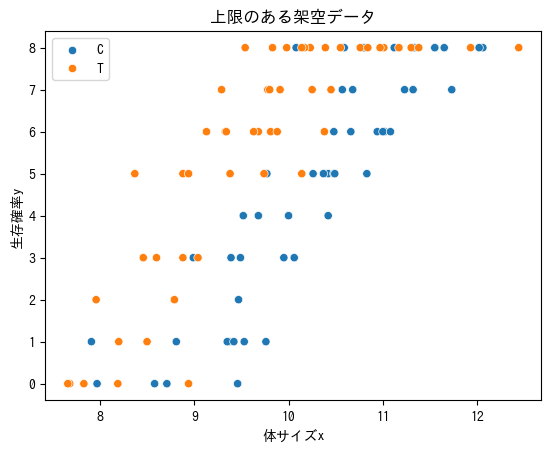

無処理のデータの個数:  50
施肥処理をしたデータの個数:  50


In [3]:
sns.scatterplot(data4a, x="x", y="y", hue="f")
plt.xlabel("体サイズx")
plt.ylabel("生存確率y")
plt.title("上限のある架空データ")
plt.legend()
plt.show()
data4a.describe()
print("無処理のデータの個数: ",(data4a["f"]=="C").sum())
print("施肥処理をしたデータの個数: ",(data4a["f"]=="T").sum())

これをみると、  
・体サイズ$x_i$が大きくなると生存種子数$y_i$が多くなってそう。  
・施肥処理をすると($f_i=T$)、生存種子数$y_i$が多くなってそう。  
ということがわかる。

<h1>6.3 二項分布で表現する「あり・なし」カウントデータ</h1>

この架空植物の種子データのように「N個のうち$y$個が生存していた」といった構造のカウントデータを統計モデルで表現するときには二項分布がよく使われます。  
このデータでは$N_i=8$という上限があるので(${0,1,2,…,N})、ポアソン分布では表現できません。  
なぜならポアソン回帰では、応答変数$y$が{$0,1,2,...$}のような「0以上だけど上限がどこにあるかわからないカウントデータ」を扱うからです。  
  
二項分布の確率分布は、  
$P(y|N,q)=\binom{N}{y}q^y(1-q)^{N-y}$  
で定義され、$P(y|N,q)$は「$N$個中の$y$個で事象が発生する」確率であり、この例ではある個体での生存確率としています。  
$\binom{N}{y}$は二項係数と呼ばれ、ここでは「$N$個の観測種子の中から$y$個の生存種子を選び出す組み合わせの数」となります。  
以下の図は様々な生起確率$q$の二項分布

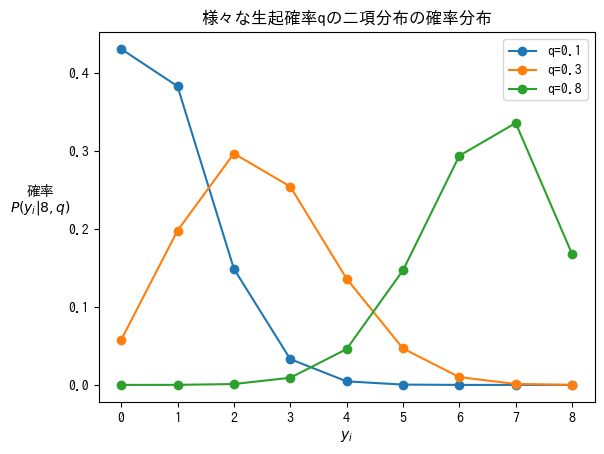

In [32]:
q_list=[0.1,0.3,0.8]
y_list = np.arange(9)
for q in q_list:
  p = [binom.pmf(y, 8, q) for y in y_list]
  plt.plot(y_list, p, marker='o',label=f"q={q}")

plt.xlabel(r"$y_i$")
plt.ylabel("確率\n"+r"$P(y_i|8,q)$", rotation=0, labelpad=20)
plt.title("様々な生起確率qの二項分布の確率分布")
plt.legend()
plt.show()